In [2]:
using LinearAlgebra, Statistics, QuantEcon, Interpolations, Optim
using Expectations, NLsolve, Roots, Random, Plots, Parameters
using LinearAlgebra, Statistics, JuMP, GLPK
using Expectations, Parameters, NLsolve, Plots

In [3]:
β = 0.98
wh = 1
wl = 0.1
πh = 0.9
πl = 0.1
r = 0.02
alow = -5
ahigh = 30
grid_size = 400

400

In [4]:
#utility function

function u(c)
    
    if c>0
        f = log(c)
    else
        f = -8
    end
    
    return f
    
end

u (generic function with 1 method)

In [5]:
grid_a = range(alow, ahigh, length = grid_size)



-5.0:0.08771929824561403:30.0

In [407]:
# T
function T(V, grid_a, β, wh, wl, alow, ahigh; compute_policy = false)
    
    prob = rand(Bernoulli(πh),1)
    u(c) = log(c)
    
    if prob == 1     # high event
        
        Ve = LinearInterpolation(grid_a,V,extrapolation_bc=Line())  # V definition support
        # an =  a next
        objectives = (an -> u(a+wh-(an/(1+r))) + β * Ve(an) for a in grid_a)
        results = maximize.(objectives, [alow,high]) # solver result for each grid point
        

            #U = b + β*E(x->max(Ve_func.(x),U))
            #V = grid_w .+ β*λ*E(x->max.(Ve_func.(x),Ve_func.(grid_w))) + β*(1-λ)*((1-δ)*V .+ δ*U) 
            
    else    # low event
        
        Ve = LinearInterpolation(grid_a,V,extrapolation_bc=Line())  # V definition support
        # an =  a next
        lx = [0]; ux = [inf]
        dfc = TwiceDifferentiableConstraints(lx, ux)
        objectives = (an -> u(abs(a+wl-(an./(1+r)))) + β * Ve(an) for a in grid_a)
        results = maximize.(objectives, [alow,ahigh]) # solver result for each grid point
        
        
    end
    

    TV = Optim.maximum.(results)
    if compute_policy
        σ = Optim.maximizer.(results)
        return TV, σ
    end

    return TV
end

T (generic function with 4 methods)

In [67]:
function T(Vh, Vl, grid_a, β, wh, wl, πh, πl, alow, ahigh ; compute_policy = false)
    
    u(c) = log(c)
    
    Vh_func = LinearInterpolation(grid_a,Vh,extrapolation_bc=Line())  # V definition support
    Vl_func = LinearInterpolation(grid_a,Vl,extrapolation_bc=Line())  # V definition support
    
    objectivesh = (ap -> u.(abs(wh+a-(ap/(1+r)))) .+ β .* (πh* Vh_func.(ap)+πl* Vl_func.(ap)) for a in grid_a)
    objectivesl = (ap -> u.(abs(wl+a-(ap/(1+r)))) .+ β .* (πh* Vh_func.(ap)+πl* Vl_func.(ap)) for a in grid_a)
    
    resultsh = maximize.(objectivesh, alow, ahigh)
    resultsl = maximize.(objectivesl, alow, ahigh)
    
    TVh = Optim.maximum.(resultsh)
    TVl = Optim.maximum.(resultsl)

    return TVh, TVl;

    
    if compute_policy
        σh = Optim.maximizer.(resultsh)
        σl = Optim.maximizer.(resultsl)
        return σh, σl
    end
   
    
    
    
end

T (generic function with 3 methods)

In [ ]:

    function Vh_func(grid_a,Vh) 
        
        q  = LinearInterpolation(grid_a,Vh,extrapolation_bc=Line()) 
      
        return q
        
    end
    
    
    function Vl_func(grid_a,Vl) 
        
        q  = LinearInterpolation(grid_a,Vl,extrapolation_bc=Line()) 
      
        return q
        

    end






        register(model, :Vh_func, 3, Vh_func; autodiff = true)
        register(model, :Vl_func, 3, Vl_func; autodiff = true)




β * (πh*  Vh_func.(an)+πl*  Vl_func.(an)))

In [62]:
# Using JUMP
using JuMP
import Ipopt

function T(Vh, Vl, grid_a, β, wh, wl, πh, πl, alow, ahigh, grid_size, Vh_func, Vl_func ; compute_policy = false)

    function u(c)
        
        return log(c)
        
    end
    
    
    
    
    
    for i in 1:grid_size
        
        a = grid_a[i]

        model = Model(Ipopt.Optimizer)
        @variable(model, alow<=ap<=ahigh)
        @variable(model, an)
        register(model, :u, 1, u; autodiff = true)
        @NLobjective(model, Max, u(wh+a-(ap/(1+r)))) 
        @NLconstraint(model, c1, wh+a-(ap/(1+r)) >= 0)
        @NLconstraint(model, an == ap)
        print(model)
        optimize!(model)

        Vh[i] = objective_value(model)



        model = Model(Ipopt.Optimizer)
        @variable(model, alow<=ap<=ahigh)
        @variable(model, an)
        register(model, :u, 1, u; autodiff = true)
        @NLobjective(model, Max, u(wl+a-(ap/(1+r)))) 
        @NLconstraint(model, c1, wl+a-(ap/(1+r)) >= 0)
        @NLconstraint(model, an == ap)
        print(model)
        optimize!(model)

        Vl[i] = objective_value(model)
    
    
    end
    
    
    
    
    return Vh, Vl
    

end



T (generic function with 2 methods)

In [64]:
using Random
Random.seed!(42)
Vh_func = LinearInterpolation(grid_a,Vh,extrapolation_bc=Line())  # V definition support
Vl_func = LinearInterpolation(grid_a,Vl,extrapolation_bc=Line())  # V definition support
Vh, Vl = T(grid_a, grid_a, grid_a, β, wh, wl, πh, πl, alow, ahigh, grid_size, Vh_func, Vl_func  ; compute_policy = false)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        1



LoadError: DomainError with -4.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [68]:
Vl = zeros(grid_size) # An initial condition -- fairly arbitrary
Vh = zeros(grid_size)
a_prime = grid_a
n = 100

for i in 1:n
    Vh, Vl = T(Vh, Vl, grid_a, β, wh, wl, πh, πl, alow, ahigh, grid_size  ; compute_policy = false)
end
plot(grid_a, Vh)
plot!(grid_a, Vl)

LoadError: MethodError: no method matching (::Interpolations.Extrapolation{Float64, 1, ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, Vector{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}, BSpline{Linear{Throw{OnGrid}}}, Line{Nothing}})(::VariableRef)
Use square brackets [] for indexing an Array.
[0mClosest candidates are:
[0m  (::Interpolations.Extrapolation{T, N, ITPT, IT, ET} where {ITPT, IT, ET})([91m::Number...[39m) where {T, N} at /Users/mohammadbagherzadeh20/.julia/packages/Interpolations/3gTQB/src/extrapolation/extrapolation.jl:45
[0m  (::Interpolations.Extrapolation{T, N, ITPT, IT, ET} where {ITPT, IT, ET})([91m::Union{Number, AbstractVector{T} where T}...[39m) where {T, N} at /Users/mohammadbagherzadeh20/.julia/packages/Interpolations/3gTQB/src/extrapolation/extrapolation.jl:54

In [382]:
using Random
Random.seed!(42)
b = T(grid_a, grid_a, β, wh, wl, alow, ahigh; compute_policy = false)

400-element Vector{Float64}:
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
 21.39999941069529
  ⋮
 28.12383376423187
 28.21151797475817
 28.299202185284496
 28.386886395810816
 28.474570606337135
 28.56225481686343
 28.649939027389763
 28.73762323791608
 28.82530744844239
 28.91299165896872
 29.00067586949503
 29.088360080021335

In [69]:
V = grid_a # An initial condition -- fairly arbitrary
a_prime = grid_a
n = 500

for i in 1:n
    V = T(V, grid_a, β, wh, wl, alow, ahigh; compute_policy = false)
end
plot(grid_a, V)

LoadError: MethodError: no method matching T(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, ::Float64, ::Int64, ::Float64, ::Int64, ::Int64; compute_policy=false)
[0mClosest candidates are:
[0m  T(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; compute_policy) at In[67]:1
[0m  T(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; compute_policy) at In[50]:5
[0m  T(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; compute_policy) at In[62]:5

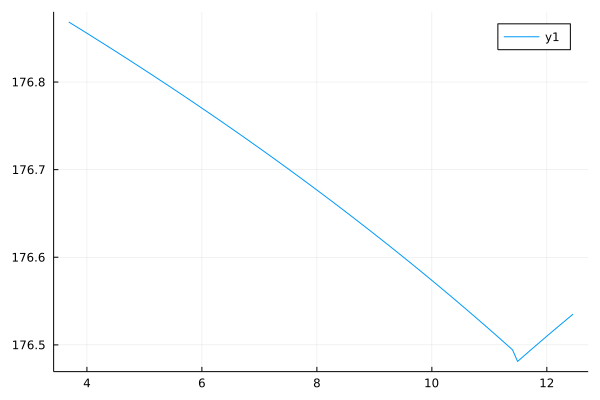

In [395]:
plot(grid_a[100:200], Vh[100:200])

In [301]:
V, a_prime = T(V, grid_a, β, wh, wl, alow, ahigh; compute_policy = true)

([-1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8, -1.0000005798516503e8  …  -61.47704493689603, -61.21898174400514, -60.962267864274466, -60.70688928726586, -60.45283220979215, -60.200083031377574, -59.94862834999551, -59.69845495809147, -59.4495498388982, -59.201900163043945], [9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463, 9.999999722317463  …  9.313496534427232, 9.388813805093251, 9.464131070262667, 9.539448330242761, 9.614765464566009, 9.690082752846532, 9.76539994715033, 9.84071720760145, 9.916034443551718, 9.99135176291438])

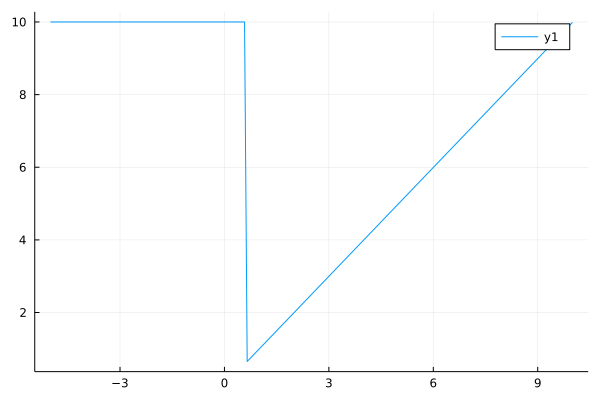

In [302]:
plot(grid_a, a_prime)

In [297]:
# fixed point solver

function solve_optgrowth(initial_V; tol = 1e-6, max_iter = 500)
    fixedpoint(V -> T(V, grid_a, β, wh, wl, alow, ahigh), initial_V).zero # gets returned
end

solve_optgrowth (generic function with 1 method)

In [298]:
initial_V = grid_a
v_star_approx = solve_optgrowth(initial_V)

plot(grid_a, v_star_approx, label = "approximate value function")

LoadError: setindex! not defined for StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}

In [11]:
cr = 1
Ve = grid_a

for i in 1:4000
    Ve = T(Ve, grid_a, β, wh, wl, alow, ahigh ; compute_policy = false)
    cr = abs(maximum(TVu-Vu))
    Vu = TVu
    if cr<1e-11
        break
    end
end

V, U, w̄ = T(Ve,Vu, grid_w, β, λ, δ; compute_policy = true)
w̄

0.7678391959798995

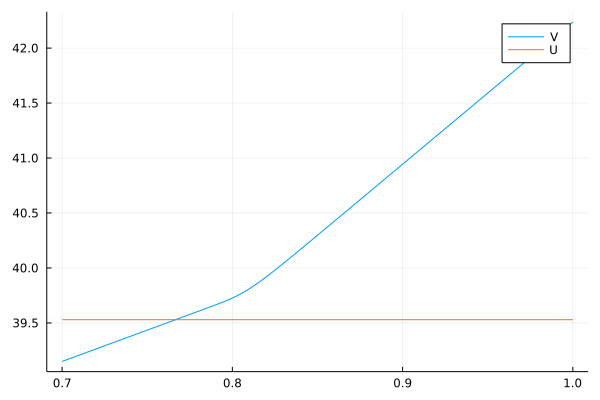

In [12]:
U_vec = fill(U, 200)
plot(w, [V U_vec], label = ["V" "U"])

In [13]:
function reservation_wage(λ,δ)
    
    Vu = 1
    cr = 1
    Ve = grid_w

    for i in 1:4000
        Ve, TVu = T(Ve,Vu, grid_w, β, λ, δ; compute_policy = false)
        cr = abs(maximum(TVu-Vu))
        Vu = TVu
        if cr<1e-11
            break
        end
    end

    V, U, w̄ = T(Ve,Vu, grid_w, β, λ, δ; compute_policy = true)
    
    return w̄
end
    

reservation_wage (generic function with 1 method)

In [14]:
grid_size = 25
R1 = rand(grid_size)

λ_vals = range(0, 0.5, length = grid_size)

for (i, λ) in enumerate(λ_vals)
        w̄1 = reservation_wage(λ, δ)
        R1[i] = w̄1
end

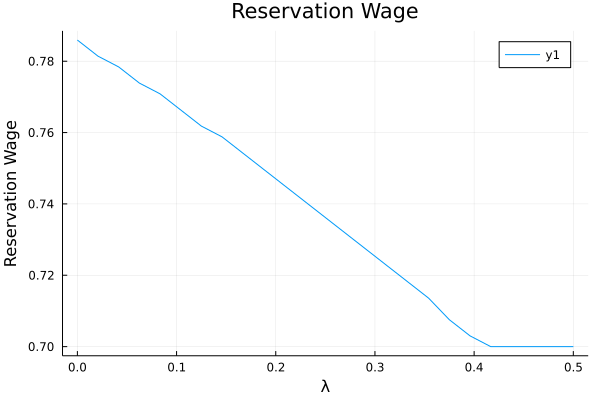

In [15]:
plot(λ_vals, R1,
        title = "Reservation Wage",
        xlabel = "λ",
        ylabel = "Reservation Wage")

In [16]:
# For planning in periods
# As we computed before
λ = 0.23
δ = 0.065
b = 0.55
Res = 0.7678391959798995

w_offer = rand(Frechet(θ),1000,500)
w_work = zeros(1000,500)
state = zeros(1000,500)
new_offer = zeros(1000,500)

for i in 1:500
   dest = rand(Bernoulli(δ),1000) # destruction
   offer = rand(Bernoulli(λ),1000) 
    if i>1
         for j in 1:1000
            if w_offer[j,i] > Res && offer[j]==1
                w_work[j,i] = w_offer[j,i]
                state[j,i] = 1
                new_offer[j,i] = 1
            elseif state[j,i-1] == 0 
                state[j,i] = 0
                w_work[j,i] = b
            end
        end

        for j in 1:1000
            if state[j,i-1] == 1 
                if dest[j] == 1
                    state[j,i] = 0
                    w_work[j,i] = b
                elseif new_offer[j,i] == 0
                    state[j,i] = 1
                    w_work[j,i] = w_work[j,i-1]
                end
            end
        end
    else
        for j in 1:1000
            if w_offer[j,i] > Res && offer[j]==1
               w_work[j,i] = w_offer[j,i] 
               state[j,i] = 1
            else
               w_work[j,i] = b 
            end
        end
    end
end

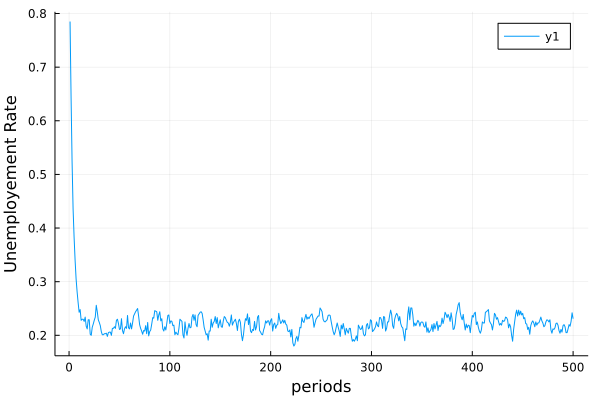

In [17]:
iter = 1:500
plot(iter, (sum(ones(1000,500)- state, dims=1)/1000)',xlabel="periods",ylabel="Unemployement Rate")

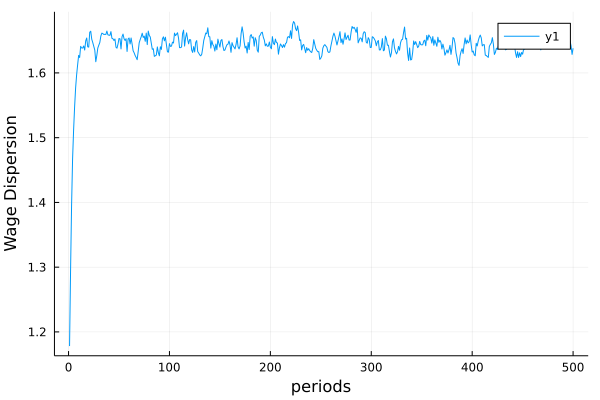

In [18]:
Mm = mean(w_work, dims=1)./minimum(w_work, dims=1)
plot(iter, Mm',xlabel="periods",ylabel="Wage Dispersion")

In [19]:
# Calibration Just λ 


avgunemployed = 0.07
b = 0.55
z = 0.8
θ = 100
λ = 0.1
δ = 0.065
β = 0.98
Res = 0.7678391959798995

grid_size = 100
D1 = zeros(grid_size)
x = 1

λ_vals = range(0, 0.2, length = grid_size)

for (q, λ) in enumerate(λ_vals)
        w̄2 = reservation_wage(λ, δ)
        Res = w̄2

        w_offer = rand(Frechet(θ,z),1000,500)
        w_work = zeros(1000,500)
        state = zeros(1000,500)
        new_offer = zeros(1000,500)

        for i in 1:500
           dest = rand(Bernoulli(δ),1000) # destruction
           offer = rand(Bernoulli(λ),1000) 
            if i>1
                 for j in 1:1000
                    if w_offer[j,i] > Res && offer[j]==1
                        w_work[j,i] = w_offer[j,i]
                        D1[q] = D1[q] + 1                         # I use this as my moment (switching employers)
                        state[j,i] = 1
                        new_offer[j,i] = 1
                    elseif state[j,i-1] == 0 
                        state[j,i] = 0
                        w_work[j,i] = b
                    end
                end

                for j in 1:1000
                    if state[j,i-1] == 1 
                        if dest[j] == 1
                            state[j,i] = 0
                            w_work[j,i] = b
                        elseif new_offer[j,i] == 0
                            state[j,i] = 1
                            w_work[j,i] = w_work[j,i-1]
                        end
                    end
                end
            else
                for j in 1:1000
                    if w_offer[j,i] > Res && offer[j]==1
                       w_work[j,i] = w_offer[j,i] 
                       state[j,i] = 1
                    else
                       w_work[j,i] = b 
                    end
                end
            end
        end
    
    
    
end

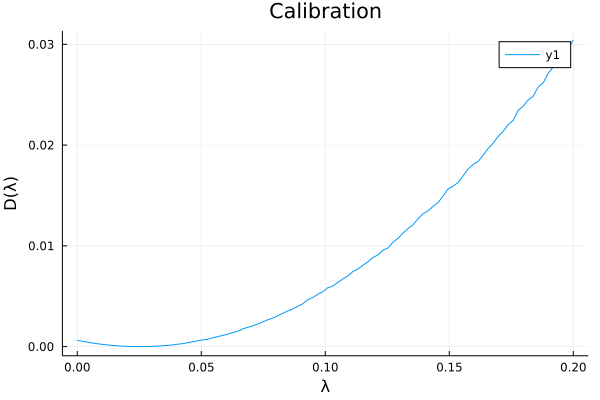

In [20]:
D = zeros(100)

switchingrate = 0.03  # from Shimer 2010

for i in 1:100
    D[i] = ((D1[i])/(1000*500) - 0.025)^2
end

plot(λ_vals, D,
        title = "Calibration",
        xlabel = "λ",
        ylabel = "D(λ)")

In [21]:
@show λ_vals[argmin(D)]

λ_vals[argmin(D)] = 0.024242424242424242


0.024242424242424242

In [55]:
# Calibration with both λ and δ


avgunemployed = 0.07
b = 0.55
z = 0.8
θ = 100
λ = 0.1
δ = 0.065
β = 0.98
Res = 0.7678391959798995

grid_size = 20
D2 = zeros(grid_size,grid_size,2)
x = 1

δ_vals = range(0.05, 0.5, length = grid_size)
λ_vals = range(0.05, 0.8, length = grid_size)

for (q, λ) in enumerate(λ_vals)
    for (p, δ) in enumerate(δ_vals)
        
        w̄2 = reservation_wage(λ, δ)
        Res = w̄2

        w_offer = rand(Frechet(θ,z),1000,500)
        w_work = zeros(1000,500)
        state = zeros(1000,500)
        new_offer = zeros(1000,500)

        for i in 1:500
           dest = rand(Bernoulli(δ),1000) # destruction
           offer = rand(Bernoulli(λ),1000) 
            if i>1
                 for j in 1:1000
                    if w_offer[j,i] > Res && offer[j]==1
                        w_work[j,i] = w_offer[j,i]
                        D2[q,p,1] = D2[q,p,1] + 1                         # I use this as my moment (switching employers)
                        state[j,i] = 1
                        new_offer[j,i] = 1
                    elseif state[j,i-1] == 0 
                        state[j,i] = 0
                        w_work[j,i] = b
                    end
                end

                for j in 1:1000
                    if state[j,i-1] == 1 
                        if dest[j] == 1
                            state[j,i] = 0
                            w_work[j,i] = b
                        elseif new_offer[j,i] == 0
                            state[j,i] = 1
                            w_work[j,i] = w_work[j,i-1]
                        end
                    end
                end
            else
                for j in 1:1000
                    if w_offer[j,i] > Res && offer[j]==1
                       w_work[j,i] = w_offer[j,i] 
                       state[j,i] = 1
                    else
                       w_work[j,i] = b 
                    end
                end
            end
        end

        un = (sum(ones(1000,500) - state, dims=1)/1000)'
        x = mean(un[460:500])                                             # average
    
        D2[q,p,2] = x - avgunemployed                              # and here I use this a second moment for δ
    
    
    end  
end

In [56]:
Dnew = zeros(grid_size,grid_size,2)
D2d = zeros(grid_size,grid_size)

switchingrate = 0.025  # from Shimer 2010

for q in 1:grid_size # for λ 
    for p in 1:grid_size   # and δ
        Dnew[q,p,1] = ((D2[q,p,1])/(1000*500) - switchingrate)^2
        Dnew[q,p,2] = (D2[q,p,2])^2
        D2d[q,p] = Dnew[q,p,1] + Dnew[q,p,2]
    end
end

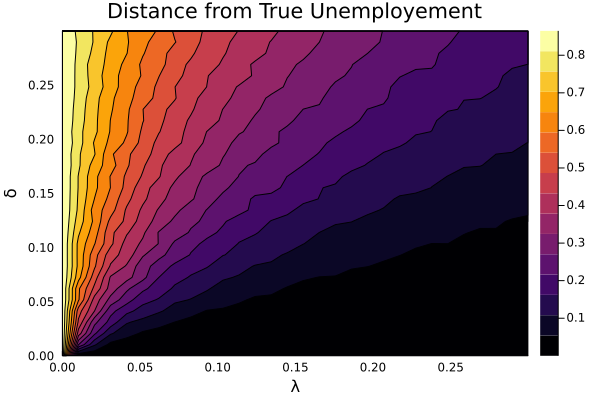

In [57]:
contour(λ_vals, δ_vals, Dnew[:,:,2]',
        title = "Distance from True Unemployement",
        xlabel = "λ",
        ylabel = "δ",
        fill = true)

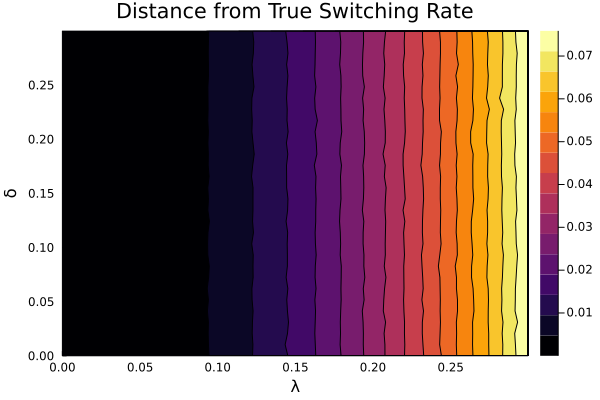

In [58]:
contour(λ_vals, δ_vals, Dnew[:,:,1]',
        title = "Distance from True Switching Rate",
        xlabel = "λ",
        ylabel = "δ",
        fill = true)

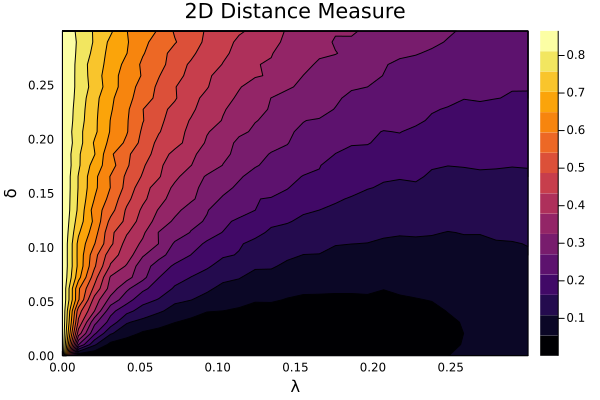

In [59]:
contour(λ_vals, δ_vals, D2d',
        title = "2D Distance Measure",
        xlabel = "λ",
        ylabel = "δ",
        fill = true)

In [60]:
argmin(D2d)

CartesianIndex(2, 1)

In [63]:
D2d[17,1]

0.0003804757475312315

In [64]:
(a,b) = (λ_vals[17], δ_vals[1])

(0.010344827586206896, 0.0)